# Showcase of single experiment.

The purpose of this notebook is to visualize and understand how a single experiment will be made.

In [81]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from matplotlib import pyplot as plt

import logging

In [2]:
# path to cleaned data file
dataFilePath = 'data/data_clean.pkl'
trainFilePath = 'data/data_train.pkl'
testFilePath = 'data/data_test.pkl'

In [3]:
# Read already prepared and saved data
with open(dataFilePath, 'rb') as f:
    data = pickle.load(f)

# Read already prepared and saved train/test datasets
with open(trainFilePath, 'rb') as f:
    data_train = pickle.load(f)

with open(testFilePath, 'rb') as f:
    data_test = pickle.load(f)

In [4]:
# Create dummy variables for categorical data
data_train = pd.get_dummies(data_train, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])
data_test = pd.get_dummies(data_test, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])

In [5]:
print('Shape of train: ', data_train.shape, '\n')
print('Columns of train: ', data_train.columns, '\n')
print('Shape of test: ', data_test.shape, '\n')
print('Columns of test: ', data_test.columns, '\n')

Shape of train:  (1251, 40) 

Columns of train:  Index(['age', 'psa', 'biopsy_gleason', 'survival_months', 'pathologic_gleason',
       'survival_months_bcr', 'survival_months_mts', 'patient_id', 'bcr',
       'mts', 'death_from_other_causes', 'cancer_specific_mortality',
       'clinical_stage_1', 'clinical_stage_2', 'clinical_stage_3',
       'biopsy_gleason_gg_1', 'biopsy_gleason_gg_2', 'biopsy_gleason_gg_3',
       'biopsy_gleason_gg_4', 'biopsy_gleason_gg_5',
       'pathological_gleason_gg_1', 'pathological_gleason_gg_2',
       'pathological_gleason_gg_3', 'pathological_gleason_gg_4',
       'pathological_gleason_gg_5', 'pathologic_stage_0', 'pathologic_stage_1',
       'pathologic_stage_2', 'lni_0.0', 'lni_1.0', 'lni_unknown',
       'surgical_margin_status_0', 'surgical_margin_status_1',
       'persistent_psa_0', 'persistent_psa_1', 'TRYSgrupes_0', 'TRYSgrupes_1',
       'TRYSgrupes_2', 'PLNDO1_0', 'PLNDO1_1'],
      dtype='object') 

Shape of test:  (313, 40) 

Columns of te

First things first, as we have 4 response variable, will have to remove those variables from the feature set which will be fed into the training.  
For this experimentation, we'll focus on cancer specific mortality (target_column)

In [6]:
# List of columns names which will be dropped from feature set before fitting the model
target_columns = ['cancer_specific_mortality', 'death_from_other_causes', 'bcr', 'mts']
target_column = 'cancer_specific_mortality'

target_columns.remove(target_column)
df_train = data_train.copy().drop(target_columns, axis=1)
df_test = data_test.copy().drop(target_columns, axis=1)

Now our training set will contain features needed for fitting a model + additional columns which will be handled later on (survival_months, survival_months_bcr, survival_months_mts, patient_id).  
Note that our training set still contains a target column (cancer_specific_mortality) but this will be removed from the dataset before fitting a model.

In [7]:
print(df_train.columns)

Index(['age', 'psa', 'biopsy_gleason', 'survival_months', 'pathologic_gleason',
       'survival_months_bcr', 'survival_months_mts', 'patient_id',
       'cancer_specific_mortality', 'clinical_stage_1', 'clinical_stage_2',
       'clinical_stage_3', 'biopsy_gleason_gg_1', 'biopsy_gleason_gg_2',
       'biopsy_gleason_gg_3', 'biopsy_gleason_gg_4', 'biopsy_gleason_gg_5',
       'pathological_gleason_gg_1', 'pathological_gleason_gg_2',
       'pathological_gleason_gg_3', 'pathological_gleason_gg_4',
       'pathological_gleason_gg_5', 'pathologic_stage_0', 'pathologic_stage_1',
       'pathologic_stage_2', 'lni_0.0', 'lni_1.0', 'lni_unknown',
       'surgical_margin_status_0', 'surgical_margin_status_1',
       'persistent_psa_0', 'persistent_psa_1', 'TRYSgrupes_0', 'TRYSgrupes_1',
       'TRYSgrupes_2', 'PLNDO1_0', 'PLNDO1_1'],
      dtype='object')


In [8]:
print(df_test.columns)

Index(['age', 'psa', 'biopsy_gleason', 'survival_months', 'pathologic_gleason',
       'survival_months_bcr', 'survival_months_mts', 'patient_id',
       'cancer_specific_mortality', 'clinical_stage_1', 'clinical_stage_2',
       'clinical_stage_3', 'biopsy_gleason_gg_1', 'biopsy_gleason_gg_2',
       'biopsy_gleason_gg_3', 'biopsy_gleason_gg_4', 'biopsy_gleason_gg_5',
       'pathological_gleason_gg_1', 'pathological_gleason_gg_2',
       'pathological_gleason_gg_3', 'pathological_gleason_gg_4',
       'pathological_gleason_gg_5', 'pathologic_stage_0', 'pathologic_stage_1',
       'pathologic_stage_2', 'lni_0.0', 'lni_1.0', 'lni_unknown',
       'surgical_margin_status_0', 'surgical_margin_status_1',
       'persistent_psa_0', 'persistent_psa_1', 'TRYSgrupes_0', 'TRYSgrupes_1',
       'TRYSgrupes_2', 'PLNDO1_0', 'PLNDO1_1'],
      dtype='object')


We'll be using a simple logistic regression model

In [9]:
# Define the model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', random_state=0)

Because our 2 response variables (mts and bcr) have different survival time column assigned, we'll determine which to use based on target_column:

In [10]:
# mts and bcr have different survival months columns
match target_column:
    case 'mts':
        time = 'survival_months_mts'
    case 'bcr':
        time = 'survival_months_bcr'
    case _:
        time = 'survival_months'

print(time)

survival_months


## Exploding training set  
Now we will explode our training set:

clip(lower, upper) function will help us create a new discrete survival time column. If we specify lower=1 and upper=200, patients who experienced event earlier than 200th month will only have records till their event, on other side, if a patient survived past 200th month, we will clip this information and will only keep information about him til 200th month.

Another example, if we specify lower=140 and upper=200, and if the person experienced event at 100th month, we will create records for him till 140th (lower boundary) month.

In [11]:
df_train_copy = df_train.copy()

target_column_discrete = target_column + '_discrete'

# We create a new time column and clip the data by provided min and max survival times
df_train_copy['survival_time_discrete'] = df_train_copy[time].clip(1,200).apply(range)

# Exploding the dataset with the created range value in new time column
data_exploded = df_train_copy.explode('survival_time_discrete')
data_exploded.reset_index(drop=True, inplace=True)

# New column starts at 0, we'll increase each value by 1
data_exploded['survival_time_discrete'] = pd.to_numeric(data_exploded['survival_time_discrete']) + 1

# New event column, which will indicate the last event date
data_exploded[target_column_discrete] = (data_exploded['survival_time_discrete'] >= data_exploded[time]) * pd.to_numeric(data_exploded[target_column])

After exploding a dataset, we see our row count went from 1251 (one record per patient) to 134666 (multiple records per patient). We also added 2 new columns (survival_time_discrete and cancer_specific_mortality_discrete)

In [12]:
print(f'dataset shape BEFORE exploding: {df_train.shape}')
print(f'dataset shape AFTER exploding: {data_exploded.shape}')

dataset shape BEFORE exploding: (1251, 37)
dataset shape AFTER exploding: (134666, 39)


In [13]:
print('Patient ids who experienced cancer specific mortality in training set:')
print(data_train.loc[data_train['cancer_specific_mortality'] == '1'].patient_id.values)

print('\nPatient ids who experienced cancer specific mortality in training set:')
print(data_train.loc[data_train['cancer_specific_mortality'] == '0'].patient_id.values)


print('\n\nPatient ids who experienced cancer specific mortality in training set and survived past 200th month:')
print(data_train.loc[(data_train['cancer_specific_mortality'] == '1') & (data_train['survival_months'] > 200)].patient_id.values)

print('\nPatient ids who experienced cancer specific mortality in training set and survived past 200th month:')
print(data_train.loc[(data_train['cancer_specific_mortality'] == '0') & (data_train['survival_months'] > 200)].patient_id.values)

Patient ids who experienced cancer specific mortality in training set:
[ 223  393   19 1051   22  624  247  844  615  111    2  855  671   30
  243  312  668  193  516  578   17  703  176  594  182  896   20 1412
   31  174 1261   28  520  155  179   34 1256   16  173   35  177  623]

Patient ids who experienced cancer specific mortality in training set:
[1194  125 1554 ... 1180  629 1205]


Patient ids who experienced cancer specific mortality in training set and survived past 200th month:
[179]

Patient ids who experienced cancer specific mortality in training set and survived past 200th month:
[1554  323  539  504  506  175  840  546   72  244  551  101  845  556
   71  557  178  316  100  593  597 1369  549  560  547  235  313  592
  561  503]


Let's look into one example of a patient who did not experienced death:

In [14]:
df_train[df_train.patient_id == 125][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality']].head()

,patient_id,age,survival_months,cancer_specific_mortality
132,125,66.0,132,0


In [15]:
data_exploded[data_exploded.patient_id == 125][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 'survival_time_discrete', 'cancer_specific_mortality_discrete']].head()

,patient_id,age,survival_months,cancer_specific_mortality,survival_time_discrete,cancer_specific_mortality_discrete
59,125,66.0,132,0,1,0
60,125,66.0,132,0,2,0
61,125,66.0,132,0,3,0
62,125,66.0,132,0,4,0
63,125,66.0,132,0,5,0


In [16]:
data_exploded[data_exploded.patient_id == 125][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 'survival_time_discrete', 'cancer_specific_mortality_discrete']].tail()

,patient_id,age,survival_months,cancer_specific_mortality,survival_time_discrete,cancer_specific_mortality_discrete
186,125,66.0,132,0,128,0
187,125,66.0,132,0,129,0
188,125,66.0,132,0,130,0
189,125,66.0,132,0,131,0
190,125,66.0,132,0,132,0


Because we only have information till 132th month for this patient, explosion only exploded the data up to 132th month, so this patient will have 132 records:

In [17]:
data_exploded[data_exploded.patient_id == 125].shape

(132, 39)

Another example, where patient did not experienced death but survived past 200th month mark:

In [18]:
df_train[df_train.patient_id == 1554][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality']].head()

,patient_id,age,survival_months,cancer_specific_mortality
1633,1554,62.0,211,0


In [19]:
data_exploded[data_exploded.patient_id == 1554][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 'survival_time_discrete', 'cancer_specific_mortality_discrete']].tail()

,patient_id,age,survival_months,cancer_specific_mortality,survival_time_discrete,cancer_specific_mortality_discrete
386,1554,62.0,211,0,196,0
387,1554,62.0,211,0,197,0
388,1554,62.0,211,0,198,0
389,1554,62.0,211,0,199,0
390,1554,62.0,211,0,200,0


In [20]:
data_exploded[data_exploded.patient_id == 1554].shape

(200, 39)

We see that this patient now only has 200 records and we clipped the records at 200th month.  
Now let's look into patients who experienced death:

In [21]:
df_train[df_train.patient_id == 223][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality']].head()

,patient_id,age,survival_months,cancer_specific_mortality
235,223,63.0,25,1


In [22]:
data_exploded[data_exploded.patient_id == 223][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 'survival_time_discrete', 'cancer_specific_mortality_discrete']].tail()

,patient_id,age,survival_months,cancer_specific_mortality,survival_time_discrete,cancer_specific_mortality_discrete
932,223,63.0,25,1,21,0
933,223,63.0,25,1,22,0
934,223,63.0,25,1,23,0
935,223,63.0,25,1,24,0
936,223,63.0,25,1,25,1


Nothing unordinary, the person survived for 25th months and we clipped the explosion at 25th month and the last record marks the event - cancer specific mortality.  
Now let's look into example where patient died after our trainable max month - 200

In [23]:
df_train[df_train.patient_id == 179][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality']].head()

,patient_id,age,survival_months,cancer_specific_mortality
188,179,54.0,203,1


In [24]:
data_exploded[data_exploded.patient_id == 179][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 'survival_time_discrete', 'cancer_specific_mortality_discrete']].tail()

,patient_id,age,survival_months,cancer_specific_mortality,survival_time_discrete,cancer_specific_mortality_discrete
95582,179,54.0,203,1,196,0
95583,179,54.0,203,1,197,0
95584,179,54.0,203,1,198,0
95585,179,54.0,203,1,199,0
95586,179,54.0,203,1,200,0


In [25]:
data_exploded[data_exploded.patient_id == 179].shape

(200, 39)

We see that even though the person experienced event at 203rd month, we have not captured this in the exploded dataset and in the exploded dataset, we will have 200 records, where the last record sill shows that the person did not experienced event.

## Fitting a model  
Now we will fit our model with the exploded dataset

In [26]:
target_column_discrete = target_column + '_discrete'

# Drop targets/features from feature set
x_columns_to_drop = [target_column, target_column_discrete, 'survival_months', 'survival_months_bcr', 'survival_months_mts', 'patient_id']
X_train = data_exploded.drop(x_columns_to_drop, axis=1)    
y_train = data_exploded[target_column_discrete]

Now the fitting of model will use a feature set X_train, note that this set now only contains feature set and does not contain target column. This set also contains our newly created survival_time_discrete column. The y_train is our response - cancer_specific_mortality_discrete.

In [27]:
print(X_train.columns)

Index(['age', 'psa', 'biopsy_gleason', 'pathologic_gleason',
       'clinical_stage_1', 'clinical_stage_2', 'clinical_stage_3',
       'biopsy_gleason_gg_1', 'biopsy_gleason_gg_2', 'biopsy_gleason_gg_3',
       'biopsy_gleason_gg_4', 'biopsy_gleason_gg_5',
       'pathological_gleason_gg_1', 'pathological_gleason_gg_2',
       'pathological_gleason_gg_3', 'pathological_gleason_gg_4',
       'pathological_gleason_gg_5', 'pathologic_stage_0', 'pathologic_stage_1',
       'pathologic_stage_2', 'lni_0.0', 'lni_1.0', 'lni_unknown',
       'surgical_margin_status_0', 'surgical_margin_status_1',
       'persistent_psa_0', 'persistent_psa_1', 'TRYSgrupes_0', 'TRYSgrupes_1',
       'TRYSgrupes_2', 'PLNDO1_0', 'PLNDO1_1', 'survival_time_discrete'],
      dtype='object')


In [28]:
print(y_train.name)

cancer_specific_mortality_discrete


In [29]:
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

## Evaluating the model  
Once we fitted a model with exploded dataset, we have to evaluate it.

### Training set  
To evaluate a model, we'll have to explode the training set again (previous exploded dataset used for training looks a bit different) and it will be done a bit different, we will see how. Now, instead of exploding the dataset with the range [1; 200], we will explode it only for [200; 200], this means that for each patient, we will have 200 records as the lower boundary equals to upper boundary, so the maximum and minimum records per patient will be the same = 200.

#### Exploding the dataset

In [45]:
# Test on training data
df_train_copy = df_train.copy()

target_column_discrete = target_column + '_discrete'

# We create a new time column and clip the data by provided min and max survival times
df_train_copy['survival_time_discrete'] = df_train_copy[time].clip(200,200).apply(range)

# Exploding the dataset with the created range value in new time column
data_exploded = df_train_copy.explode('survival_time_discrete')
data_exploded.reset_index(drop=True, inplace=True)

# New column starts at 0, we'll increase each value by 1
data_exploded['survival_time_discrete'] = pd.to_numeric(data_exploded['survival_time_discrete']) + 1

# New event column, which will indicate the last event date
data_exploded[target_column_discrete] = (data_exploded['survival_time_discrete'] >= data_exploded[time]) * pd.to_numeric(data_exploded[target_column])

target_column_cumulative = target_column + '_cumulative'

# Create new event column with duplicated event values from discrete column
data_exploded[target_column_cumulative] = data_exploded[target_column_discrete]

# For cumulative events, after end_time we will have NA values, we'll replace those with event indicator
after_survival_time = data_exploded['survival_time_discrete'] > data_exploded[time]
data_exploded.loc[after_survival_time, target_column_discrete] = -1
data_exploded[target_column_discrete] = data_exploded[target_column_discrete].replace(-1,np.NaN)
data_exploded.loc[(after_survival_time & (data_exploded[target_column]==0)), target_column_cumulative] = -1
data_exploded[target_column_cumulative] = data_exploded[target_column_cumulative].replace(-1,np.NaN)

Indeed, if we look into number of unique patients and the number of rows we have in exploded dataset, we see that per patient we have 200 rows:

In [51]:
print(f'Unique patients: {len(pd.unique(data_exploded.patient_id))}')
print(f'Rows in exploded dataset: {data_exploded.shape[0]}')
print(f'\n{data_exploded.shape[0]} / {len(pd.unique(data_exploded.patient_id))} = {data_exploded.shape[0] / len(pd.unique(data_exploded.patient_id))} ')

Unique patients: 1251
Rows in exploded dataset: 250200

250200 / 1251 = 200.0 


In [57]:
data_exploded[(data_exploded.patient_id == 623) & (data_exploded.survival_time_discrete.isin([37, 38, 39, 40, 41]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative']]

,patient_id,age,survival_months,cancer_specific_mortality,survival_time_discrete,cancer_specific_mortality_discrete,cancer_specific_mortality_cumulative
250036,623,68.0,39,1,37,0.0,0
250037,623,68.0,39,1,38,0.0,0
250038,623,68.0,39,1,39,1.0,1
250039,623,68.0,39,1,40,NaN,1
250040,623,68.0,39,1,41,NaN,1


Now we have, that for this patient, who experienced cancer specific mortality at 39th month, we added much more records. At discrete time, 39th month is the month when the event has occured
but after that, in discrete mortality column, all records past 39th month will be NaN. Newly added cumulative column will continue showing event occurence after 39th month up to our max time = 200

#### Using the model to predict mortality  
We've came to the fun part -> using our model to predict mortality probabilities for this dataset.  
To do so, we'll also remove columns which are not used for the prediction.

In [60]:
x_columns_to_drop = [target_column, target_column+'_discrete', target_column+'_cumulative', 'survival_months', 'survival_months_bcr', 'survival_months_mts', 'patient_id']
X_df = data_exploded.drop(x_columns_to_drop, axis=1)

# probabilities
y_pred = model.predict_proba(X_df)[:,1]
data_exploded['mortality_instant_prob'] = y_pred

In [61]:
data_exploded[(data_exploded.patient_id == 623) & (data_exploded.survival_time_discrete.isin([37, 38, 39, 40, 41]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob']]

,patient_id,age,survival_months,cancer_specific_mortality,survival_time_discrete,cancer_specific_mortality_discrete,cancer_specific_mortality_cumulative,mortality_instant_prob
250036,623,68.0,39,1,37,0.0,0,0.000886
250037,623,68.0,39,1,38,0.0,0,0.000896
250038,623,68.0,39,1,39,1.0,1,0.000906
250039,623,68.0,39,1,40,NaN,1,0.000916
250040,623,68.0,39,1,41,NaN,1,0.000926


What our model did is it calculated a probability that a patient will experience an event right at that specific timestamp (for example 39th month after diagnosis).  
We call this instant mortality probability. Now, instant probability usually is not what we are looking for, we are looking for a probability of event UP TO Xth month.  
So in reality, we have to calculate cumulative mortality porbability:

In [64]:
data_copy = data_exploded.copy()

#data_copy = data_copy[ ['patient_id', 'mortality_instant_prob'] ]

data_copy['negative_log_prob'] = np.log( 1 - data_copy['mortality_instant_prob'] )

data_copy['cumulative_hazard'] = 1 - np.exp(data_copy.groupby('patient_id')['negative_log_prob'].transform(pd.Series.cumsum))

In [67]:
data_copy[data_copy.patient_id == 623][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'negative_log_prob', 'cumulative_hazard']]

,patient_id,age,survival_months,cancer_specific_mortality,survival_time_discrete,cancer_specific_mortality_discrete,cancer_specific_mortality_cumulative,mortality_instant_prob,negative_log_prob,cumulative_hazard
250000,623,68.0,39,1,1,0.0,0,0.000594,-0.000595,0.000594
250001,623,68.0,39,1,2,0.0,0,0.000601,-0.000601,0.001195
250002,623,68.0,39,1,3,0.0,0,0.000608,-0.000608,0.001802
250003,623,68.0,39,1,4,0.0,0,0.000615,-0.000615,0.002416
250004,623,68.0,39,1,5,0.0,0,0.000621,-0.000622,0.003036
...,...,...,...,...,...,...,...,...,...,...
250195,623,68.0,39,1,196,NaN,1,0.005155,-0.005169,0.339995
250196,623,68.0,39,1,197,NaN,1,0.005213,-0.005226,0.343435
250197,623,68.0,39,1,198,NaN,1,0.005270,-0.005284,0.346895
250198,623,68.0,39,1,199,NaN,1,0.005329,-0.005343,0.350376


Now we have both - instant probability and cumulative hazard. Cumulative hazard simply can be thought like: at 2th month the calculation looks like:  
1 - ((1 - 0.000601) * (1 - 0.000594)) = 0.0011946...  
Using this cumulative hazard, we can calculate AUC metrics

#### AUC for single slice  
Now that we have our predictions and we exploded the dataset with cumulative events, let's calculate AUC metric:

We will do one slice for this experiment, let's see how well we predict <= 24 months:

In [73]:
month = 24

# Selecting a subset of data based on the months
select = (data_copy['survival_time_discrete'] == month) & pd.notna(data_copy[target_column+'_cumulative'])
sub_dat = data_copy[select]

In [74]:
sub_dat

,age,psa,biopsy_gleason,survival_months,pathologic_gleason,survival_months_bcr,survival_months_mts,patient_id,cancer_specific_mortality,clinical_stage_1,...,TRYSgrupes_1,TRYSgrupes_2,PLNDO1_0,PLNDO1_1,survival_time_discrete,cancer_specific_mortality_discrete,cancer_specific_mortality_cumulative,mortality_instant_prob,negative_log_prob,cumulative_hazard
23,73.0,6.36,6.0,59,7.0,34,39,1194,0,0,...,1,0,1,0,24,0.0,0,0.000201,-0.000201,0.004241
223,66.0,10.40,7.0,132,7.0,132,132,125,0,0,...,0,1,0,1,24,0.0,0,0.000131,-0.000131,0.002775
423,62.0,8.05,4.0,211,4.0,207,207,1554,0,0,...,0,0,1,0,24,0.0,0,0.000849,-0.000849,0.017829
623,69.0,16.05,6.0,101,6.0,38,38,267,0,0,...,1,0,0,1,24,0.0,0,0.000032,-0.000032,0.000668
823,66.0,7.22,7.0,46,7.0,11,11,1204,0,0,...,1,0,1,0,24,0.0,0,0.000154,-0.000154,0.003267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249223,68.0,5.69,7.0,49,7.0,24,24,1201,0,1,...,1,0,1,0,24,0.0,0,0.000034,-0.000034,0.000730
249423,60.0,7.21,6.0,32,7.0,32,32,1180,0,0,...,1,0,1,0,24,0.0,0,0.000085,-0.000085,0.001795
249623,64.0,5.36,6.0,171,7.0,159,159,629,0,0,...,0,1,1,0,24,0.0,0,0.000179,-0.000179,0.003789
249823,64.0,4.19,7.0,41,7.0,19,19,1205,0,0,...,1,0,1,0,24,0.0,0,0.000031,-0.000031,0.000654


We've selected a subset of exploded dataset, this subset now only has one record per patient -> for each patient, we have his information and his cumulative hazards

In [77]:
# If in the sliced data there's a event, calculate AUC metric,
# otherwise assign NaN value
if sub_dat[target_column+'_cumulative'].max() == 1:
    fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
    auc_stat = auc(fpr, tpr)
else:
    auc_stat = float('NaN')
print(f'FPR: {fpr}\n\nTPR: {tpr}\n\nthresholds: {thresholds}\n\nAUC: {auc_stat}')

FPR: [0.00000000e+00 8.01282051e-04 2.40384615e-03 2.40384615e-03
 1.28205128e-02 1.28205128e-02 4.24679487e-02 4.24679487e-02
 1.00000000e+00]

TPR: [0.         0.         0.         0.33333333 0.33333333 0.66666667
 0.66666667 1.         1.        ]

thresholds: [1.30201527e+00 3.02015272e-01 2.25318352e-01 1.94946260e-01
 1.00522476e-01 9.44695323e-02 2.77850091e-02 2.73780256e-02
 2.43064075e-05]

AUC: 0.9807692307692308


We have AUC of 0.98! While this may look good, remember we are only predicting first 24 months..  
Looking into the subset of data that we've sliced, we only have 3 events which occurded up to 24th month:

In [78]:
print(sub_dat.shape)
print('\n',sub_dat.cancer_specific_mortality_cumulative.value_counts())
print('\n',sub_dat.cancer_specific_mortality.value_counts())
print('\n',sub_dat.cancer_specific_mortality_discrete.value_counts())

(1251, 43)

 0    1248
1       3
Name: cancer_specific_mortality_cumulative, dtype: int64

 0    1209
1      42
Name: cancer_specific_mortality, dtype: int64

 0.0    1188
Name: cancer_specific_mortality_discrete, dtype: int64


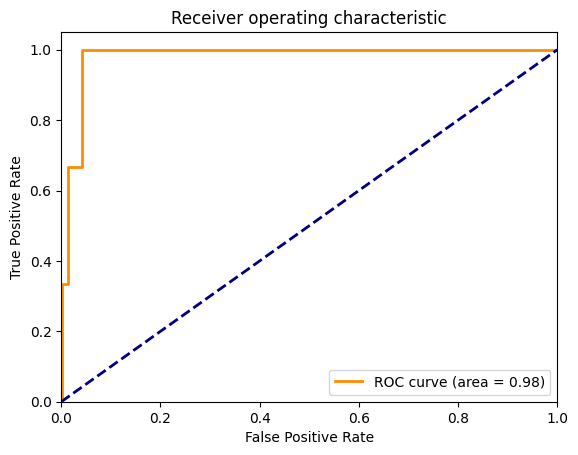

In [82]:
# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc_stat,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

We can use the thresholds from the ROC calculation and see how can we predict the mortality..  
We use the first threshold:

In [90]:
sub_X_test = sub_dat.drop(['survival_months', 'patient_id', 'cancer_specific_mortality',
                          'patient_id', 'cancer_specific_mortality_discrete',
                          'survival_months_bcr', 'survival_months_mts',
                           'cancer_specific_mortality_cumulative',
                           'mortality_instant_prob', 'negative_log_prob', 'cumulative_hazard'], axis=1)

temp_y_pred = (model.predict_proba(sub_X_test)[:,1] >= thresholds[0] ).astype(int)

In [91]:
pd.Series(temp_y_pred).value_counts()

0    1251
dtype: int64

Not good, we predicted all cases as non-event (we havent predicted any cancer related mortality)

In [93]:
print(confusion_matrix(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred), '\n')
print(classification_report(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred, zero_division=0), '\n')
print(auc_stat)

[[1248    0]
 [   3    0]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1248
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1251
   macro avg       0.50      0.50      0.50      1251
weighted avg       1.00      1.00      1.00      1251
 

0.9807692307692308


We can also try another threshold:

In [132]:
sub_X_test = sub_dat.drop(['survival_months', 'patient_id', 'cancer_specific_mortality',
                          'patient_id', 'cancer_specific_mortality_discrete',
                          'survival_months_bcr', 'survival_months_mts',
                           'cancer_specific_mortality_cumulative',
                           'mortality_instant_prob', 'negative_log_prob', 'cumulative_hazard'], axis=1)

temp_threshold = 0.0012

temp_y_pred = (model.predict_proba(sub_X_test)[:,1] >= temp_threshold ).astype(int)

print(f'threshold: >= {temp_threshold:.8f}\n')

print(pd.Series(temp_y_pred).value_counts(), '\n\n')

print(confusion_matrix(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred), '\n')
print(classification_report(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred, zero_division=0), '\n')
print(auc_stat)

threshold: >= 0.00120000

0    1189
1      62
dtype: int64 


[[1189   59]
 [   0    3]] 

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1248
           1       0.05      1.00      0.09         3

    accuracy                           0.95      1251
   macro avg       0.52      0.98      0.53      1251
weighted avg       1.00      0.95      0.97      1251
 

0.9807692307692308


Now we see we predicted 62 cancer related mortalities, out of those 62, 3 cancer mortalities were predicted correctly but we also  
said 59 patient experienced mortality while in reality they have not (at least up to our selected month).
Our model has 95% accuracy (this is misleading as we have imbalanced dataset). Precision of event class is only 5% but the recall is 100%, for non-event class, the precision is 100% and recall is 95%

#### AUC for multiple slices  
Now that we know how to calculate AUC for a single slice, we can calculate for more slices.

In [135]:
# AUC for each cumulative slice
# Months at which we'll check the AUC's
months = list(range(6, 200 + 6, 6))

train_auc_stats = []
for month in months:
    # --- Training data ---
    # Selecting a subset of data based on the months
    select = (data_copy['survival_time_discrete'] == month) & pd.notna(data_copy[target_column+'_cumulative'])
    sub_dat = data_copy[select]

    # If in the sliced data there's a event, calculate AUC metric,
    # otherwise assign NaN value
    if sub_dat[target_column+'_cumulative'].max() == 1:
        fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
        auc_stat = auc(fpr, tpr)
    else:
        auc_stat = float('NaN')
    train_auc_stats.append(auc_stat)

auc_stats = pd.DataFrame(zip(months, train_auc_stats),
                        columns=['month', 'train_auc'])

print(auc_stats)

    month  train_auc
0       6        NaN
1      12        NaN
2      18   0.986400
3      24   0.980769
4      30   0.956627
5      36   0.963482
6      42   0.970894
7      48   0.972536
8      54   0.972536
9      60   0.969050
10     66   0.953998
11     72   0.906664
12     78   0.903210
13     84   0.907127
14     90   0.910736
15     96   0.912749
16    102   0.912667
17    108   0.900582
18    114   0.887694
19    120   0.888651
20    126   0.891815
21    132   0.894430
22    138   0.888879
23    144   0.888879
24    150   0.891089
25    156   0.891089
26    162   0.891089
27    168   0.891089
28    174   0.891089
29    180   0.891089
30    186   0.891089
31    192   0.891089
32    198   0.888712
33    204        NaN


We see that for the first 2 slices (6 and 12 months) we don't have events, so we also don't compute AUC values.  
We also see a trend, the longer the period we predict, the worse AUC gets. Predicting a mortality up to 198th month  
gives us AUC value of 0.88.